# Library imports


In [18]:
# basic libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# image manipulation libraries
from PIL import Image
from pillow_heif import register_heif_opener #suppsoe iphone heif format, run "pip install pillow_heif" in terminal

# pytorch libraries for running cnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models


# Reading images from the folder structure


In [19]:
your_cat_folder = "Mackenzie"
other_cat_folder = "OtherTabby"

# Register HEIC support
register_heif_opener()

# Define paths
base_path = "images"
your_cat_path = os.path.join(base_path, your_cat_folder)
other_cat_path = os.path.join(base_path, other_cat_folder)

# Load your_cat images
your_cat_images = []
for filename in os.listdir(your_cat_path):
    if filename.endswith((".heic", ".jpg", ".jpeg")):
        img_path = os.path.join(your_cat_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                your_cat_images.append(img.copy())  # Copy to avoid file lock
            #print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Load other_cat images
other_cat_images = []
for filename in os.listdir(other_cat_path):
    if filename.endswith((".heic", ".jpg", ".jpeg")):
        img_path = os.path.join(other_cat_path, filename)
        try:
            with Image.open(img_path) as img:
                img = img.convert('RGB')
                other_cat_images.append(img.copy())  # Copy to avoid file lock
            #print(f"Successfully loaded {filename}")
        except Exception as e:
            print(f"Error loading {filename}: {e}")

# Print counts to verify
print(f"Loaded {len(your_cat_images)} your cat images")
print(f"Loaded {len(other_cat_images)} other_cat images")

Loaded 164 your cat images
Loaded 3012 other_cat images


# Split data


In [20]:
max_count = 300
testset_percentage = 0.2

# Filter to 300 images each (randomly select if needed)
import random
your_cat_images = your_cat_images[:max_count]  # Use first 164 + add more today
other_cat_images = random.sample(other_cat_images, max_count)  # Random 300 from 3012

# Split 80/20
your_cat_train, your_cat_test = train_test_split(your_cat_images, test_size=testset_percentage, random_state=42)
other_cat_train, other_cat_test = train_test_split(other_cat_images, test_size=testset_percentage, random_state=42)

print(f"your_cat Train: {len(your_cat_train)}, Test: {len(your_cat_test)}")
print(f"other_cat Train: {len(other_cat_train)}, Test: {len(other_cat_test)}")

your_cat Train: 131, Test: 33
other_cat Train: 240, Test: 60


In [21]:
def manipulate_image(img):
    # Rotate (random angle 0-360)
    angle = random.randint(0, 360)
    img = img.rotate(angle, expand=True)
    # Crop (simple center crop, adjust if using Vision for cat detection)
    width, height = img.size
    new_size = min(width, height)
    left = (width - new_size) / 2
    top = (height - new_size) / 2
    img = img.crop((left, top, left + new_size, top + new_size))
    # Resize to 224x224
    img = img.resize((224, 224), Image.Resampling.LANCZOS)
    return img

# Apply to a sample
sample_img = your_cat_train[0]
manipulated_img = manipulate_image(sample_img)
manipulated_img.save("manipulated_sample.jpg")

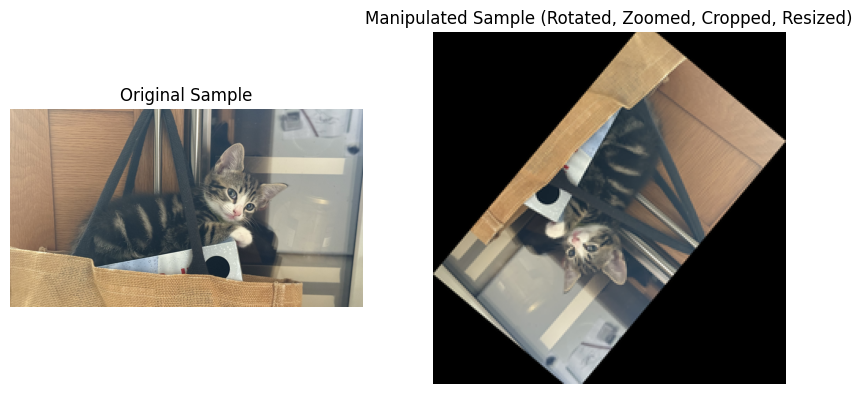

In [22]:
# Sample image from your_cat
sample_img = your_cat_train[0]

# Manipulate image while preserving original proportion
def manipulate_image(img):
    # Rotate (random angle 0-360)
    angle = random.randint(0, 360) #giving some random rotation for training
    img_rotated = img.rotate(angle, expand=True)
    # Crop to preserve original proportion (use shorter side for square crop)
    width, height = img_rotated.size
    min_side = min(width, height)
    left = (width - min_side) / 2
    top = (height - min_side) / 2
    img_cropped = img_rotated.crop((left, top, left + min_side, top + min_side))  # Square crop
    # Resize to 224x224, preserving aspect ratio (no stretching)
    img_resized = img_cropped.resize((224, 224), Image.Resampling.LANCZOS)
    return img_resized

manipulated_img = manipulate_image(sample_img)

# Save and display
sample_img.save("original_sample.jpg")
manipulated_img.save("manipulated_sample.jpg")

# Display side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original Sample")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(manipulated_img)
plt.title("Manipulated Sample (Rotated, Zoomed, Cropped, Resized)")
plt.axis("off")
plt.show()

In [23]:
#training


In [24]:
# hyperparameter
cnn_epoch_count = 5


# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels  # 1 for your_cat, 0 for other_cat
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms (include your manipulation)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL to tensor
    transforms.Resize((224, 224)),  # Resize
    transforms.RandomRotation(360),  # Rotate
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),  # Zoom/crop
])

# Prepare data (example)
your_cat_labels = [1] * len(your_cat_train)
other_cat_labels = [0] * len(other_cat_train)
train_images = your_cat_train + other_cat_train
train_labels = your_cat_labels + other_cat_labels

dataset = CatDataset(train_images, train_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Detect CUDA or Metal (MPS) or fallback to CPU
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Metal on Apple Silicon
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# CNN Model (fine-tune ResNet18)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Quick test (no full training yet)
for epoch in range(cnn_epoch_count):
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")

Using device: mps


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 loss: 0.42838572897017
Epoch 2 loss: 0.44276607409119606
Epoch 3 loss: 0.21927404031157494
Epoch 4 loss: 0.1332665467634797
Epoch 5 loss: 0.12163210924093922


In [25]:
# save the model

In [26]:
torch.save(model.state_dict(), "wheresmytabby_cnn.pth")

Test Accuracy: 92.47311827956989%


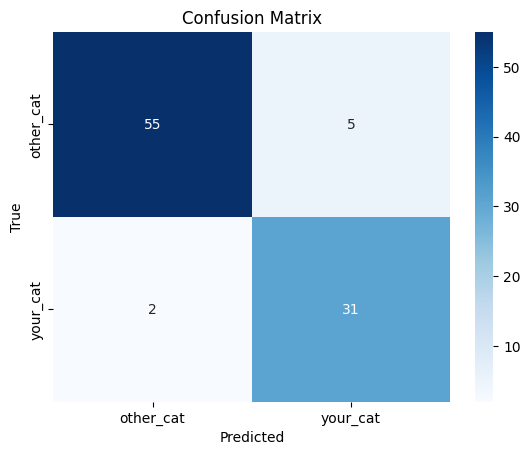

In [27]:
# Custom Dataset
class CatDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
])

# Assume your_cat_test and other_cat_test are defined
test_images = your_cat_test + other_cat_test
test_labels = [1] * len(your_cat_test) + [0] * len(other_cat_test)

# Test Dataset and Dataloader
test_dataset = CatDataset(test_images, test_labels, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load("wheresmytabby_cnn.pth"))  # Updated model file
model = model.to(device)
model.eval()

# Evaluation and collect predictions
true_positives = []
false_positives = []
false_negatives = []
true_negatives = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(len(labels)):
            if labels[i] == 1 and predicted[i] == 1:
                true_positives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 0 and predicted[i] == 1:
                false_positives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 1 and predicted[i] == 0:
                false_negatives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))
            elif labels[i] == 0 and predicted[i] == 0:
                true_negatives.append((images[i].cpu(), labels[i].item(), predicted[i].item()))

# Calculate accuracy
true_labels = []
pred_labels = []
for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    pred_labels.extend(predicted.cpu().numpy())
total = len(true_labels)
correct = sum(1 for t, p in zip(true_labels, pred_labels) if t == p)
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")


cm = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['other_cat', 'your_cat'], yticklabels=['other_cat', 'your_cat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0045270706..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00037680575..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00417311..1.0000001].


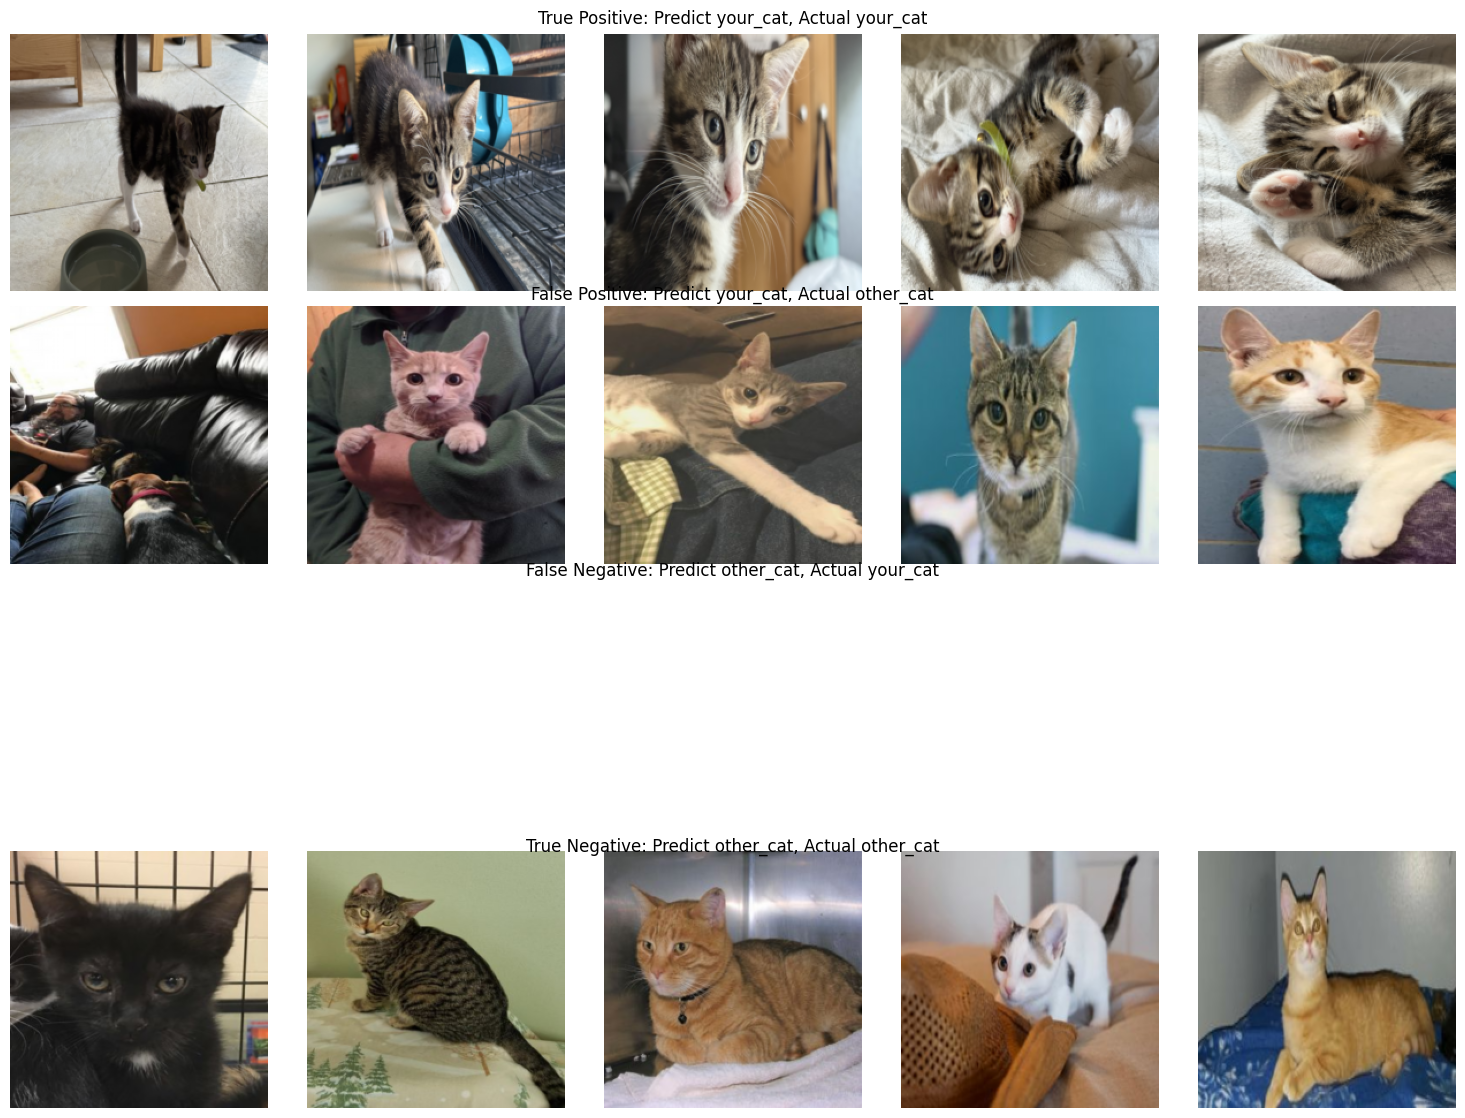

In [17]:
# Display examples (max 5 per category)
fig = plt.figure(figsize=(15, 12))  # Increased height for spacing

# Row titles with more spacing
titles = [
    "True Positive: Predict your_cat, Actual your_cat",
    "False Positive: Predict your_cat, Actual other_cat",
    "False Negative: Predict other_cat, Actual your_cat",
    "True Negative: Predict other_cat, Actual other_cat"
]
fig.text(0.5, 0.95, titles[0], ha='center', va='center', fontsize=12)  # Top row
fig.text(0.5, 0.72, titles[1], ha='center', va='center', fontsize=12)  # 2nd row
fig.text(0.5, 0.49, titles[2], ha='center', va='center', fontsize=12)  # 3rd row
fig.text(0.5, 0.26, titles[3], ha='center', va='center', fontsize=12)  # 4th row

# Row 1: True Positives
tp_indices = np.random.choice(len(true_positives), min(5, len(true_positives)), replace=False)
for i, idx in enumerate(tp_indices):
    img, _, _ = true_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")

# Row 2: False Positives
fp_indices = np.random.choice(len(false_positives), min(5, len(false_positives)), replace=False)
for i, idx in enumerate(fp_indices):
    img, _, _ = false_positives[idx]
    img = img.numpy().transpose((1, 2, 0))
    plt.subplot(4, 5, i + 6)
    plt.imshow(img)
    plt.axis("off")

# Row 3: False Negatives
fn_indices = np.random.choice(len(false_negatives), min(5, len(false_negatives)), replace=False)
for i, idx in enumerate(fn_indices):
    img, _, _ = false_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    plt.subplot(4, 5, i + 11)
    plt.imshow(img)
    plt.axis("off")

# Row 4: True Negatives
tn_indices = np.random.choice(len(true_negatives), min(5, len(true_negatives)), replace=False)
for i, idx in enumerate(tn_indices):
    img, _, _ = true_negatives[idx]
    img = img.numpy().transpose((1, 2, 0))
    plt.subplot(4, 5, i + 16)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusted rect for title spacing
plt.show()